In [1]:
# Initialize a new VAME project
import functions_bondjango as bd
import functions_vame as fv
import paths
import vame
import random
import os
import shutil

In [2]:
# # Manually define the config path if project has already been created
# config = r"F:\VAME_projects\VAME_prey_3-Feb28-2021\config.yaml"

In [3]:
# get the file paths

# define the number of files to use
number_files = 0
# define the search string
search_string = 'rig:miniscope'

# define the target model
target_model = 'video_experiment'
# get the queryset
files = bd.query_database(target_model, search_string)

if number_files > 0:
    # pick a random subset of number_files
    files = random.sample(files, number_files)

# get the video paths in a list
video_paths = [el['avi_path'] for el in files]

# define the working directory
working_directory = paths.vame_path

In [4]:
print(files[0]['preproc_files'][0])

dlc_path = files[0]['avi_path']
dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')
print(dlc_path)

09_08_2020_15_56_34_miniscope_dg_200617_b_succ_injured_nofluo_preprocessing
J:\Drago Guggiana Nilo\Prey_capture\AnalyzedData\09_08_2020_15_56_34_miniscope_DG_200617_b_succ_injured_nofluo_preproc.hdf5


In [5]:
# initialize the project
config = vame.init_new_project(project='VAME_prey_3', videos=video_paths, working_directory=working_directory, videotype='.avi')

Created "F:\VAME_projects\VAME_prey_3-Mar7-2021\videos"
Created "F:\VAME_projects\VAME_prey_3-Mar7-2021\data"
Created "F:\VAME_projects\VAME_prey_3-Mar7-2021\results"
Created "F:\VAME_projects\VAME_prey_3-Mar7-2021\model"
Copying the videos 

A VAME project has been created. 

Next use vame.create_trainset(config) to split your data into a train and test set. 
Afterwards you can use vame.rnn_model() to train the model on your data.


In [6]:
# Align video trajectories

# get the project folder
project_folder, _ = os.path.split(config)

# for all the videos
for el in files:
    print(f'Current file: {el["slug"]}')
    
    # if there is no preprocessing file, skip and warn
    if len(el['preproc_files']) == 0:
        print('no preprocessing file found')
        continue
    # load the avi file path
    dlc_path = el['avi_path']
    # edit it for the preprocessing path
    dlc_path = dlc_path.replace('.avi', '_preproc.hdf5')
    dlc_path = dlc_path.replace('VideoExperiment', 'AnalyzedData')
    dlc_path = dlc_path.replace('VRExperiment', 'AnalyzedData')

    # define the cropping
    crop_size = (1, 1)
    # egocentrically align the data and save
    fv.run_alignment(dlc_path, project_folder, '.avi', crop_size)


Current file: 09_08_2020_15_56_34_miniscope_dg_200617_b_succ_injured_nofluo


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 10041.15it/s]


Current file: 09_08_2020_15_54_36_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_50_32_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_47_44_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 11102.98it/s]


Current file: 09_08_2020_15_43_03_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_39_45_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_36_13_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 148/148 [00:00<00:00, 6285.13it/s]


Current file: 09_08_2020_15_32_30_miniscope_dg_200617_b_succ
Current file: 09_08_2020_15_26_21_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_23_32_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 10730.11it/s]


Current file: 09_08_2020_15_20_34_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_16_25_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_13_51_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145/145 [00:00<00:00, 8534.94it/s]


Current file: 09_08_2020_15_10_07_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_06_13_miniscope_dg_200701_a_succ
Current file: 09_08_2020_15_03_49_miniscope_dg_200701_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 8331.06it/s]


Current file: 09_08_2020_15_00_07_miniscope_dg_200701_a_succ
Current file: 09_07_2020_15_41_46_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_38_41_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 8054.44it/s]


Current file: 09_07_2020_15_35_51_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_32_36_miniscope_dg_200617_b_succ_injured
Current file: 09_07_2020_15_29_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 8729.80it/s]


Current file: 09_07_2020_15_26_46_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_23_07_miniscope_dg_200617_b_succ
Current file: 09_07_2020_15_18_17_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 8597.85it/s]

Current file: 09_07_2020_15_02_53_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_59_11_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 13867.12it/s]


Current file: 09_07_2020_14_57_17_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_53_42_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_51_32_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:00<00:00, 7596.85it/s]


Current file: 09_07_2020_14_48_19_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_45_29_miniscope_dg_200701_a_succ
Current file: 09_07_2020_14_42_14_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:00<00:00, 9497.41it/s]


Current file: 09_06_2020_15_51_43_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_47_33_miniscope_dg_200617_b_succ_injured
Current file: 09_06_2020_15_43_13_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:00<00:00, 11381.42it/s]


Current file: 09_06_2020_15_38_32_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_35_22_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_31_55_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 12006.95it/s]


Current file: 09_06_2020_15_28_50_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_25_10_miniscope_dg_200617_b_succ
Current file: 09_06_2020_15_18_22_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 12737.26it/s]


Current file: 09_06_2020_15_14_12_miniscope_dg_200701_a_succ
Current file: 09_06_2020_15_11_37_miniscope_dg_200701_a_succ
Current file: 09_06_2020_15_09_11_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:00<00:00, 10455.46it/s]

Current file: 09_06_2020_15_05_22_miniscope_dg_200701_a_succ
Current file: 09_06_2020_15_02_17_miniscope_dg_200701_a_succ
Current file: 09_06_2020_14_58_24_miniscope_dg_200701_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [00:00<00:00, 6839.17it/s]


Current file: 09_06_2020_14_55_10_miniscope_dg_200701_a_succ_injured
Current file: 09_05_2020_16_30_05_miniscope_dg_200617_b_succ_injured
Current file: 09_05_2020_16_26_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 178/178 [00:00<00:00, 8897.57it/s]


Current file: 09_05_2020_16_23_03_miniscope_dg_200617_b_succ
Current file: 09_05_2020_16_19_09_miniscope_dg_200617_b_succ
Current file: 09_05_2020_16_16_21_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 11471.68it/s]


Current file: 09_05_2020_16_12_58_miniscope_dg_200617_b_succ
Current file: 09_05_2020_16_09_14_miniscope_dg_200617_b_succ
Current file: 09_05_2020_16_06_30_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 11306.75it/s]


Current file: 09_05_2020_15_59_18_miniscope_dg_200701_a_succ
Current file: 09_05_2020_15_56_40_miniscope_dg_200701_a_succ
Current file: 09_05_2020_15_52_46_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/357 [00:00<?, ?it/s]

Current file: 09_05_2020_15_50_02_miniscope_dg_200701_a_succ
Current file: 09_05_2020_15_47_48_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 7074.72it/s]


Current file: 09_05_2020_15_45_35_miniscope_dg_200701_a_succ_injured
Current file: 09_05_2020_15_42_56_miniscope_dg_200701_a_succ
Current file: 09_05_2020_15_40_48_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:00<00:00, 9998.13it/s]


Current file: 09_04_2020_17_26_53_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_23_03_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_17_48_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 8331.48it/s]


Current file: 09_04_2020_17_14_08_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_11_33_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_07_37_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9529.26it/s]


Current file: 09_04_2020_17_03_57_miniscope_dg_200617_b_succ
Current file: 09_04_2020_17_00_52_miniscope_dg_200617_b_succ
Current file: 09_04_2020_16_52_56_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 8677.18it/s]


Current file: 09_04_2020_16_49_06_miniscope_dg_200701_a_succ_injured
Current file: 09_04_2020_16_46_11_miniscope_dg_200701_a_succ_distractedbytrash
Current file: 09_04_2020_16_43_01_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 13005.24it/s]


Current file: 09_04_2020_16_39_31_miniscope_dg_200701_a_succ
Current file: 09_04_2020_16_35_52_miniscope_dg_200701_a_succ
Current file: 09_04_2020_16_33_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:00<00:00, 8885.06it/s]


Current file: 09_04_2020_16_30_05_miniscope_dg_200701_a_succ_injured
Current file: 09_03_2020_16_47_03_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_43_43_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/362 [00:00<?, ?it/s]

Current file: 09_03_2020_16_40_53_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_36_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:00<00:00, 8560.17it/s]

Current file: 09_03_2020_16_31_10_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_28_25_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:00<00:00, 9179.15it/s]


Current file: 09_03_2020_16_24_34_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_21_39_miniscope_dg_200617_b_succ
Current file: 09_03_2020_16_15_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 9158.65it/s]


Current file: 09_03_2020_16_12_49_miniscope_dg_200701_a_succ
Current file: 09_03_2020_16_09_44_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 183/183 [00:00<00:00, 8796.42it/s]


Current file: 09_03_2020_16_06_54_miniscope_dg_200701_a_succ_injured
Current file: 09_03_2020_16_03_07_miniscope_dg_200701_a_succ
Current file: 09_03_2020_15_59_43_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 8105.18it/s]


Current file: 09_03_2020_15_57_43_miniscope_dg_200701_a_succ
Current file: 09_03_2020_15_54_14_miniscope_dg_200701_a_succ
Current file: 09_02_2020_17_38_56_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [00:00<00:00, 12939.46it/s]


Current file: 09_02_2020_17_35_23_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_32_19_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_27_37_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 9208.13it/s]


Current file: 09_02_2020_17_24_54_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_21_30_miniscope_dg_200617_b_succ
Current file: 09_02_2020_17_17_37_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 214/214 [00:00<00:00, 10197.81it/s]


Current file: 09_02_2020_17_13_08_miniscope_dg_200617_b_succ
Current file: 09_02_2020_16_55_43_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_53_10_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 261/261 [00:00<00:00, 8999.47it/s]


Current file: 09_02_2020_16_50_16_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_45_55_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 10703.46it/s]


Current file: 09_02_2020_16_41_25_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_37_35_miniscope_dg_200701_a_succ
Current file: 09_02_2020_16_34_36_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 8052.77it/s]


Current file: 09_02_2020_16_30_27_miniscope_dg_200701_a_succ_injured
Current file: 09_01_2020_16_58_35_miniscope_dg_200617_b_succ_injured
Current file: 09_01_2020_16_55_25_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [00:00<00:00, 11960.39it/s]

Current file: 09_01_2020_16_52_15_miniscope_dg_200617_b_succ_injured
Current file: 09_01_2020_16_47_10_miniscope_dg_200617_b_succ
Current file: 09_01_2020_16_43_46_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 227/227 [00:00<00:00, 9875.09it/s]


Current file: 09_01_2020_16_39_52_miniscope_dg_200617_b_succ_injured
Current file: 09_01_2020_16_34_42_miniscope_dg_200617_b_succ
Current file: 09_01_2020_16_29_24_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 9641.56it/s]


Current file: 09_01_2020_16_20_52_miniscope_dg_200701_a_succ
Current file: 09_01_2020_16_17_14_miniscope_dg_200701_a_succ
Current file: 09_01_2020_16_14_05_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 13133.19it/s]


Current file: 09_01_2020_16_10_27_miniscope_dg_200701_a_succ
Current file: 09_01_2020_16_07_13_miniscope_dg_200701_a_succ
Current file: 09_01_2020_16_03_24_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 8574.97it/s]

Current file: 09_01_2020_15_59_31_miniscope_dg_200701_a_succ
Current file: 09_01_2020_15_56_27_miniscope_dg_200701_a_succ
Current file: 08_31_2020_16_42_25_miniscope_dg_200617_b_succ_injured



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 8827.36it/s]


Current file: 08_31_2020_16_39_00_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_36_15_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_32_34_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 13706.22it/s]


Current file: 08_31_2020_16_29_59_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_26_28_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_22_19_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 8204.59it/s]


Current file: 08_31_2020_16_17_53_miniscope_dg_200617_b_succ
Current file: 08_31_2020_16_10_12_miniscope_dg_200701_a_succ
Current file: 08_31_2020_16_05_52_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 8217.73it/s]


Current file: 08_31_2020_16_01_53_miniscope_dg_200701_a_succ
Current file: 08_31_2020_15_59_34_miniscope_dg_200701_a_succ
Current file: 08_31_2020_15_54_51_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 11435.89it/s]


Current file: 08_31_2020_15_50_06_miniscope_dg_200701_a_succ
Current file: 08_31_2020_15_46_43_miniscope_dg_200701_a_succ
Current file: 08_31_2020_15_41_54_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:00<00:00, 8587.80it/s]

Current file: 08_30_2020_16_35_54_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_31_45_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 9665.37it/s]

Current file: 08_30_2020_16_28_07_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_24_08_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_20_40_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 11509.56it/s]


Current file: 08_30_2020_16_17_16_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_14_23_miniscope_dg_200617_b_succ
Current file: 08_30_2020_16_10_58_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 8373.02it/s]


Current file: 08_30_2020_16_03_21_miniscope_dg_200701_a_succ
Current file: 08_30_2020_15_59_37_miniscope_dg_200701_a_succ_injured
Current file: 08_30_2020_15_56_29_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 7632.91it/s]


Current file: 08_30_2020_15_53_35_miniscope_dg_200701_a_succ_injured
Current file: 08_30_2020_15_50_51_miniscope_dg_200701_a_succ
Current file: 08_30_2020_15_47_33_miniscope_dg_200701_a_succ_injured


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 13722.29it/s]


Current file: 08_30_2020_15_44_44_miniscope_dg_200701_a_succ
Current file: 08_30_2020_15_40_53_miniscope_dg_200701_a_succ
Current file: 08_29_2020_16_54_07_miniscope_dg_200617_b_succ_nofluo


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 11963.19it/s]


Current file: 08_29_2020_16_50_48_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_46_00_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_42_06_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 8796.72it/s]


Current file: 08_29_2020_16_38_23_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_33_45_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_31_16_miniscope_dg_200617_b_succ_injured


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 208/208 [00:00<00:00, 11550.12it/s]


Current file: 08_29_2020_16_26_47_miniscope_dg_200617_b_succ
Current file: 08_29_2020_16_17_59_miniscope_dg_200701_a_succ
Current file: 08_29_2020_16_15_31_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 10356.31it/s]

Current file: 08_29_2020_16_12_42_miniscope_dg_200701_a_succ
Current file: 08_29_2020_16_08_29_miniscope_dg_200701_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:00<00:00, 8782.32it/s]

Current file: 08_29_2020_16_04_30_miniscope_dg_200701_a_succ
Current file: 08_29_2020_16_01_17_miniscope_dg_200701_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 389/389 [00:00<00:00, 9267.68it/s]

Current file: 08_29_2020_15_58_33_miniscope_dg_200701_a_succ
Current file: 08_29_2020_15_55_24_miniscope_dg_200701_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [00:00<00:00, 8906.50it/s]

Current file: 08_21_2020_16_33_02_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_28_13_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 13371.85it/s]


Current file: 08_21_2020_16_24_35_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_18_56_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_12_47_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 9742.22it/s]


Current file: 08_21_2020_16_08_48_miniscope_dg_200617_b_succ
Current file: 08_21_2020_16_03_54_miniscope_dg_200617_b_succ
Current file: 08_21_2020_15_58_04_miniscope_dg_200617_b_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 207/207 [00:00<00:00, 8598.97it/s]

Current file: 08_21_2020_15_48_23_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_45_14_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_42_56_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 10617.37it/s]


Current file: 08_21_2020_15_39_23_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_36_39_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_34_25_miniscope_dg_200701_a_succ_injured


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 10339.10it/s]

Current file: 08_21_2020_15_32_26_miniscope_dg_200701_a_succ
Current file: 08_21_2020_15_29_32_miniscope_dg_200701_a_succ
Current file: 08_20_2020_16_43_39_miniscope_dg_200617_b_succ_injured



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 10871.22it/s]


Current file: 08_20_2020_16_40_35_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_36_12_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_31_59_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 9878.59it/s]


Current file: 08_20_2020_16_27_00_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_23_32_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_18_53_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:00<00:00, 11818.97it/s]


Current file: 08_20_2020_16_13_59_miniscope_dg_200617_b_succ
Current file: 08_20_2020_16_06_26_miniscope_dg_200701_a_succ
Current file: 08_20_2020_16_03_02_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 12047.73it/s]


Current file: 08_20_2020_15_57_27_miniscope_dg_200701_a_succ_grabbedcable
Current file: 08_20_2020_15_54_48_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 238/238 [00:00<00:00, 11895.76it/s]


Current file: 08_20_2020_15_51_33_miniscope_dg_200701_a_succ
Current file: 08_20_2020_15_48_39_miniscope_dg_200701_a_succ
Current file: 08_20_2020_15_43_36_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 271/271 [00:00<00:00, 12916.55it/s]


Current file: 08_20_2020_15_40_41_miniscope_dg_200701_a_succ
Current file: 08_19_2020_16_55_33_miniscope_dg_200617_b_succ
Current file: 08_19_2020_16_52_39_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 10844.98it/s]

Current file: 08_19_2020_16_50_11_miniscope_dg_200617_b_succ
Current file: 08_19_2020_16_44_52_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/277 [00:00<?, ?it/s]

Current file: 08_19_2020_16_39_04_miniscope_dg_200617_b_succ
Current file: 08_19_2020_16_35_29_miniscope_dg_200617_b_succ_injured


Align frames:   0%|                                                                                                                                                                                                                                | 0/454 [00:00<?, ?it/s]

Current file: 08_19_2020_16_33_11_miniscope_dg_200617_b_succ_injured
Current file: 08_19_2020_16_27_02_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/4069 [00:00<?, ?it/s]

Current file: 08_19_2020_16_16_55_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 11247.91it/s]

Current file: 08_19_2020_16_11_32_miniscope_dg_200701_a_succ_injured
Current file: 08_19_2020_16_09_08_miniscope_dg_200701_a_succ
Current file: 08_19_2020_16_05_59_miniscope_dg_200701_a_succ_grabbedcable



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:00<00:00, 12860.81it/s]


Current file: 08_19_2020_16_01_41_miniscope_dg_200701_a_succ
Current file: 08_19_2020_15_58_22_miniscope_dg_200701_a_succ
Current file: 08_19_2020_15_55_28_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 9009.07it/s]

Current file: 08_19_2020_15_51_39_miniscope_dg_200701_a_succ_injured
Current file: 08_18_2020_16_45_57_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 10286.51it/s]

Current file: 08_18_2020_16_41_33_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_38_40_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/478 [00:00<?, ?it/s]

Current file: 08_18_2020_16_34_54_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_31_06_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/269 [00:00<?, ?it/s]

Current file: 08_18_2020_16_28_42_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_25_33_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 239/239 [00:00<00:00, 11378.29it/s]

Current file: 08_18_2020_16_23_10_miniscope_dg_200617_b_succ
Current file: 08_18_2020_16_15_09_miniscope_dg_200701_a_succ
Current file: 08_18_2020_16_11_41_miniscope_dg_200701_a_succ_grabbedcable



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:00<00:00, 9141.55it/s]


Current file: 08_18_2020_16_08_29_miniscope_dg_200701_a_succ
Current file: 08_18_2020_16_04_51_miniscope_dg_200701_a_succ
Current file: 08_18_2020_16_01_32_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:00<00:00, 8520.94it/s]


Current file: 08_18_2020_15_59_09_miniscope_dg_200701_a_succ
Current file: 08_18_2020_15_54_55_miniscope_dg_200701_a_succ
Current file: 08_18_2020_15_51_16_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:00<00:00, 11887.21it/s]


Current file: 08_17_2020_16_25_53_miniscope_dg_200617_b_succ_injured
Current file: 08_17_2020_16_22_44_miniscope_dg_200617_b_succ_injured
Current file: 08_17_2020_16_19_31_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 191/191 [00:00<00:00, 8686.87it/s]


Current file: 08_17_2020_16_16_18_miniscope_dg_200617_b_succ
Current file: 08_17_2020_16_12_24_miniscope_dg_200617_b_succ
Current file: 08_17_2020_16_10_15_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [00:00<00:00, 8249.26it/s]


Current file: 08_17_2020_16_06_06_miniscope_dg_200617_b_succ
Current file: 08_17_2020_16_01_03_miniscope_dg_200617_b_succ
Current file: 08_17_2020_15_50_49_miniscope_dg_200701_a_succ_injured


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 8815.57it/s]


Current file: 08_17_2020_15_47_55_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_45_26_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_43_31_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 215/215 [00:00<00:00, 7917.46it/s]

Current file: 08_17_2020_15_40_54_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_38_44_miniscope_dg_200701_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 8497.58it/s]

Current file: 08_17_2020_15_36_48_miniscope_dg_200701_a_succ
Current file: 08_17_2020_15_34_07_miniscope_dg_200701_a_succ_injured
Current file: 08_16_2020_16_27_15_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [00:00<00:00, 10757.38it/s]


Current file: 08_16_2020_16_23_16_miniscope_dg_200617_b_succ_injured
Current file: 08_16_2020_16_18_28_miniscope_dg_200617_b_succ
Current file: 08_16_2020_16_15_42_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:00<00:00, 8693.25it/s]


Current file: 08_16_2020_16_13_04_miniscope_dg_200617_b_succ
Current file: 08_16_2020_16_09_31_miniscope_dg_200617_b_succ
Current file: 08_16_2020_16_07_07_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:00<00:00, 8296.31it/s]


Current file: 08_16_2020_16_04_28_miniscope_dg_200617_b_succ
Current file: 08_16_2020_15_56_30_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_52_46_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/362 [00:00<?, ?it/s]

Current file: 08_16_2020_15_50_17_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_46_53_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 8497.07it/s]

Current file: 08_16_2020_15_43_35_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_41_26_miniscope_dg_200701_a_succ_injured



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 185/185 [00:00<00:00, 8047.73it/s]


Current file: 08_16_2020_15_39_22_miniscope_dg_200701_a_succ
Current file: 08_16_2020_15_35_26_miniscope_dg_200701_a_succ
Current file: 08_15_2020_16_36_57_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/255 [00:00<?, ?it/s]

Current file: 08_15_2020_16_34_53_miniscope_dg_200617_b_succ
Current file: 08_15_2020_16_31_30_miniscope_dg_200617_b_succ_nofluo


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 9989.46it/s]

Current file: 08_15_2020_16_28_36_miniscope_dg_200617_b_succ_injured
Current file: 08_15_2020_16_25_08_miniscope_dg_200617_b_succ_injured
Current file: 08_15_2020_16_22_29_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 204/204 [00:00<00:00, 9277.92it/s]


Current file: 08_15_2020_16_18_50_miniscope_dg_200617_b_succ
Current file: 08_15_2020_16_16_11_miniscope_dg_200617_b_succ
Current file: 08_15_2020_16_12_31_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/229 [00:00<?, ?it/s]

Current file: 08_15_2020_16_05_59_miniscope_dg_200701_a_succ
Current file: 08_15_2020_16_02_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 8357.66it/s]

Current file: 08_15_2020_15_58_47_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_54_28_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_52_25_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:00<00:00, 11453.67it/s]


Current file: 08_15_2020_15_49_06_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_45_13_miniscope_dg_200701_a_succ
Current file: 08_15_2020_15_41_21_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/350 [00:00<?, ?it/s]

Current file: 08_14_2020_15_57_32_miniscope_dg_200617_b_succ
Current file: 08_14_2020_15_54_58_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:00<00:00, 10568.64it/s]

Current file: 08_14_2020_15_50_50_miniscope_dg_200617_b_succ
Current file: 08_14_2020_15_47_26_miniscope_dg_200617_b_succ_injured



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 781/781 [00:00<00:00, 10547.75it/s]

Current file: 08_14_2020_15_44_42_miniscope_dg_200617_b_succ
Current file: 08_14_2020_15_40_19_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 245/245 [00:00<00:00, 9421.77it/s]


Current file: 08_14_2020_15_37_49_miniscope_dg_200617_b_succ_injured
Current file: 08_14_2020_15_34_20_miniscope_dg_200617_b_succ_injured
Current file: 08_14_2020_15_28_27_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:00<00:00, 9825.67it/s]


Current file: 08_14_2020_15_23_43_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_21_09_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:00<00:00, 10626.70it/s]


Current file: 08_14_2020_15_17_30_miniscope_dg_200701_a_succ_injured
Current file: 08_14_2020_15_09_52_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_07_03_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 9290.92it/s]


Current file: 08_14_2020_15_04_44_miniscope_dg_200701_a_succ
Current file: 08_14_2020_15_02_32_miniscope_dg_200701_a_succ
Current file: 08_13_2020_16_35_25_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 233/233 [00:00<00:00, 9491.31it/s]


Current file: 08_13_2020_16_32_11_miniscope_dg_200617_b_succ
Current file: 08_13_2020_16_26_36_miniscope_dg_200617_b_succ
Current file: 08_13_2020_16_21_12_miniscope_dg_200617_b_succ_injured


Align frames:   0%|                                                                                                                                                                                                                                | 0/408 [00:00<?, ?it/s]

Current file: 08_13_2020_16_17_47_miniscope_dg_200617_b_succ
Current file: 08_13_2020_16_12_01_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 13086.45it/s]

Current file: 08_13_2020_16_09_18_miniscope_dg_200617_b_succ_injured
Current file: 08_13_2020_16_05_09_miniscope_dg_200617_b_succ
Current file: 08_13_2020_15_59_37_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/493 [00:00<?, ?it/s]

Current file: 08_13_2020_15_55_14_miniscope_dg_200701_a_succ
Current file: 08_13_2020_15_52_37_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [00:00<00:00, 9672.57it/s]

Current file: 08_13_2020_15_49_59_miniscope_dg_200701_a_succ_injured
Current file: 08_13_2020_15_45_14_miniscope_dg_200701_a_succ_injured



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 317/317 [00:00<00:00, 9057.68it/s]

Current file: 08_13_2020_15_42_16_miniscope_dg_200701_a_succ
Current file: 08_13_2020_15_39_43_miniscope_dg_200701_a_succ_movecam
Current file: 08_13_2020_15_36_29_miniscope_dg_200701_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 280/280 [00:00<00:00, 8750.11it/s]


Current file: 08_12_2020_16_30_56_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_24_56_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_21_45_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 8379.52it/s]

Current file: 08_12_2020_16_17_05_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_14_41_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_12_08_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/248 [00:00<?, ?it/s]

Current file: 08_12_2020_16_06_17_miniscope_dg_200617_b_succ
Current file: 08_12_2020_16_02_32_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 10562.48it/s]

Current file: 08_12_2020_15_56_49_miniscope_dg_200701_a_succ
Current file: 08_12_2020_15_51_54_miniscope_dg_200701_a_succ
Current file: 08_12_2020_15_47_44_miniscope_dg_200701_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:00<00:00, 9693.64it/s]


Current file: 08_12_2020_15_44_23_miniscope_dg_200701_a_succ_noncon
Current file: 08_12_2020_15_39_17_miniscope_dg_200701_a_succ
Current file: 08_12_2020_15_35_36_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 10298.12it/s]

Current file: 08_12_2020_15_32_21_miniscope_dg_200701_a_succ_injured
Current file: 08_12_2020_15_29_25_miniscope_dg_200701_a_succ
Current file: 08_11_2020_16_10_57_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 308/308 [00:00<00:00, 12327.12it/s]

Current file: 08_11_2020_16_06_06_miniscope_dg_200617_b_succ
Current file: 08_11_2020_16_03_21_miniscope_dg_200617_b_succ
Current file: 08_11_2020_16_00_10_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [00:00<00:00, 8830.47it/s]


Current file: 08_11_2020_15_56_40_miniscope_dg_200617_b_succ
Current file: 08_11_2020_15_51_51_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 266/266 [00:00<00:00, 6887.92it/s]


Current file: 08_11_2020_15_47_26_miniscope_dg_200617_b_succ
Current file: 08_11_2020_15_44_45_miniscope_dg_200617_b_succ
Current file: 08_11_2020_15_33_47_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 9747.45it/s]


Current file: 08_11_2020_15_31_17_miniscope_dg_200701_a_succ_injured
Current file: 08_11_2020_15_27_09_miniscope_dg_200701_a_succ_injured
Current file: 08_11_2020_15_25_00_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:00<00:00, 9003.84it/s]


Current file: 08_11_2020_15_22_04_miniscope_dg_200701_a_succ
Current file: 08_11_2020_15_17_38_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 9223.21it/s]

Current file: 08_11_2020_15_15_22_miniscope_dg_200701_a_succ
Current file: 08_11_2020_15_12_33_miniscope_dg_200701_a_succ
Current file: 08_10_2020_17_33_00_miniscope_dg_200617_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:00<00:00, 12038.23it/s]

Current file: 08_10_2020_17_27_54_miniscope_dg_200617_b_succ
Current file: 08_10_2020_17_24_14_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 260/260 [00:00<00:00, 9998.80it/s]


Current file: 08_10_2020_17_20_19_miniscope_dg_200617_b_succ
Current file: 08_10_2020_17_16_40_miniscope_dg_200617_b_succ
Current file: 08_10_2020_17_13_00_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/463 [00:00<?, ?it/s]

Current file: 08_10_2020_17_07_51_miniscope_dg_200617_b_succ_injured
Current file: 08_10_2020_17_04_35_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 281/281 [00:00<00:00, 9372.41it/s]

Current file: 08_10_2020_16_56_35_miniscope_dg_200701_a_succ_injured
Current file: 08_10_2020_16_52_15_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/292 [00:00<?, ?it/s]

Current file: 08_10_2020_16_48_58_miniscope_dg_200701_a_succ
Current file: 08_10_2020_16_44_58_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/365 [00:00<?, ?it/s]

Current file: 08_10_2020_16_41_32_miniscope_dg_200701_a_succ
Current file: 08_10_2020_16_38_11_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 6946.47it/s]

Current file: 08_10_2020_16_34_57_miniscope_dg_200701_a_succ
Current file: 08_10_2020_16_31_43_miniscope_dg_200701_a_succ
Current file: 08_09_2020_16_26_36_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/481 [00:00<?, ?it/s]

Current file: 08_09_2020_16_23_45_miniscope_dg_200617_b_succ
Current file: 08_09_2020_16_17_40_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 326/326 [00:00<00:00, 9725.68it/s]

Current file: 08_09_2020_16_13_20_miniscope_dg_200617_b_succ
Current file: 08_09_2020_16_08_16_miniscope_dg_200617_b_succ
Current file: 08_09_2020_16_03_39_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [00:00<00:00, 8776.98it/s]


Current file: 08_09_2020_16_01_33_miniscope_dg_200617_b_succ
Current file: 08_09_2020_15_57_15_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 483/483 [00:00<00:00, 10806.77it/s]

Current file: 08_09_2020_15_51_40_miniscope_dg_200701_a_succ
Current file: 08_09_2020_15_48_25_miniscope_dg_200701_a_succ_nomini



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 373/373 [00:00<00:00, 8983.08it/s]

Current file: 08_09_2020_15_44_35_miniscope_dg_200701_a_succ
Current file: 08_09_2020_15_08_18_miniscope_dg_200701_a_fail_alive



Align frames:   0%|                                                                                                                                                                                                                                | 0/557 [00:00<?, ?it/s]

Current file: 08_09_2020_15_05_48_miniscope_dg_200701_a_succ
Current file: 08_09_2020_15_03_09_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/471 [00:00<?, ?it/s]

Current file: 08_09_2020_14_59_34_miniscope_dg_200701_a_succ_injured
Current file: 08_09_2020_14_55_56_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/367 [00:00<?, ?it/s]

Current file: 08_09_2020_14_53_16_miniscope_dg_200701_a_succ
Current file: 08_08_2020_16_29_56_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 456/456 [00:00<00:00, 10355.86it/s]


Current file: 08_08_2020_16_26_31_miniscope_dg_200617_b_succ
Current file: 08_08_2020_16_18_51_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/403 [00:00<?, ?it/s]

Current file: 08_08_2020_16_15_39_miniscope_dg_200617_b_succ
Current file: 08_08_2020_16_12_42_miniscope_dg_200617_b_succ_noncon


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 765/765 [00:00<00:00, 9683.57it/s]


Current file: 08_08_2020_16_08_14_miniscope_dg_200617_b_succ
Current file: 08_08_2020_16_00_22_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [00:00<00:00, 9784.79it/s]


Current file: 08_08_2020_15_57_37_miniscope_dg_200617_b_succ
Current file: 08_08_2020_15_50_40_miniscope_dg_200701_a_succ_noncon


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 12603.28it/s]


Current file: 08_08_2020_15_47_53_miniscope_dg_200701_a_succ
Current file: 08_08_2020_15_44_28_miniscope_dg_200701_a_succ
Current file: 08_08_2020_15_38_09_miniscope_dg_200701_a_succ_injured


Align frames:   0%|                                                                                                                                                                                                                               | 0/1396 [00:00<?, ?it/s]

Current file: 08_08_2020_15_33_57_miniscope_dg_200701_a_succ_injured_noncon


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 11785.36it/s]

Current file: 08_08_2020_15_30_48_miniscope_dg_200701_a_succ
Current file: 08_08_2020_15_27_33_miniscope_dg_200701_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 553/553 [00:00<00:00, 12267.42it/s]


Current file: 08_08_2020_15_24_06_miniscope_dg_200701_a_succ
Current file: 08_07_2020_17_13_15_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/401 [00:00<?, ?it/s]

Current file: 08_07_2020_17_08_34_miniscope_dg_200617_b_succ
Current file: 08_07_2020_17_03_26_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 575/575 [00:00<00:00, 11050.08it/s]


Current file: 08_07_2020_16_57_16_miniscope_dg_200617_b_succ
Current file: 08_07_2020_16_52_22_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/401 [00:00<?, ?it/s]

Current file: 08_07_2020_16_48_37_miniscope_dg_200617_b_succ
Current file: 08_07_2020_16_43_52_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/311 [00:00<?, ?it/s]

Current file: 08_07_2020_16_39_29_miniscope_dg_200617_b_succ
Current file: 08_07_2020_16_28_48_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 549/549 [00:00<00:00, 10546.75it/s]


Current file: 08_07_2020_16_24_44_miniscope_dg_200701_a_succ_noncon
Current file: 08_07_2020_16_21_53_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/394 [00:00<?, ?it/s]

Current file: 08_07_2020_16_16_35_miniscope_dg_200701_a_succ
Current file: 08_07_2020_16_13_27_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 555/555 [00:00<00:00, 10272.35it/s]


Current file: 08_07_2020_16_08_55_miniscope_dg_200701_a_succ
Current file: 08_07_2020_16_05_16_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 436/436 [00:00<00:00, 8865.99it/s]


Current file: 08_07_2020_16_01_27_miniscope_dg_200701_a_succ
Current file: 08_06_2020_18_53_34_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 8021.46it/s]


Current file: 08_06_2020_18_50_24_miniscope_dg_200617_b_succ
Current file: 08_06_2020_18_46_29_miniscope_dg_200617_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 407/407 [00:00<00:00, 8483.78it/s]

Current file: 08_06_2020_18_42_09_miniscope_dg_200617_b_succ
Current file: 08_06_2020_18_35_22_miniscope_dg_200617_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:00<00:00, 9520.19it/s]


Current file: 08_06_2020_18_30_31_miniscope_dg_200617_b_succ
Current file: 08_06_2020_18_24_41_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/1129 [00:00<?, ?it/s]

Current file: 08_06_2020_18_15_22_miniscope_dg_200617_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 445/445 [00:00<00:00, 10246.91it/s]


Current file: 08_06_2020_18_07_32_miniscope_dg_200701_a_succ
Current file: 08_06_2020_18_02_17_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/989 [00:00<?, ?it/s]

Current file: 08_06_2020_17_58_44_miniscope_dg_200701_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 802/802 [00:00<00:00, 12525.16it/s]


Current file: 08_06_2020_17_54_57_miniscope_dg_200701_a_succ
Current file: 08_06_2020_17_47_03_miniscope_dg_200701_a_fail


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705/705 [00:00<00:00, 11616.61it/s]


Current file: 08_06_2020_17_41_32_miniscope_dg_200701_a_succ
Current file: 08_06_2020_17_37_15_miniscope_dg_200701_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 671/671 [00:00<00:00, 9447.65it/s]

Current file: 08_06_2020_17_33_37_miniscope_dg_200701_a_succ
Current file: 08_05_2020_16_20_09_miniscope_dg_200617_b_succ



Align frames:   0%|                                                                                                                                                                                                                               | 0/2345 [00:00<?, ?it/s]

Current file: 08_05_2020_16_11_00_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/1362 [00:00<?, ?it/s]

Current file: 08_05_2020_16_06_18_miniscope_dg_200617_b_succ_earlystop


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1362/1362 [00:00<00:00, 9573.76it/s]


Current file: 08_05_2020_15_55_12_miniscope_dg_200617_b_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/1199 [00:00<?, ?it/s]

Current file: 08_05_2020_15_43_21_miniscope_dg_200701_a_succ


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1075/1075 [00:00<00:00, 12077.26it/s]

Current file: 08_05_2020_15_36_29_miniscope_dg_200701_a_succ



Align frames:   0%|                                                                                                                                                                                                                               | 0/1608 [00:00<?, ?it/s]

Current file: 08_05_2020_15_29_56_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/2671 [00:00<?, ?it/s]

Current file: 08_05_2020_15_22_44_miniscope_dg_200701_a_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/4627 [00:00<?, ?it/s]

Current file: 08_04_2020_15_49_56_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4685 [00:00<?, ?it/s]

Current file: 08_04_2020_15_43_15_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4865 [00:00<?, ?it/s]

Current file: 08_04_2020_15_36_08_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4678 [00:00<?, ?it/s]

Current file: 08_04_2020_15_22_12_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4761 [00:00<?, ?it/s]

Current file: 08_04_2020_15_15_34_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4634 [00:00<?, ?it/s]

Current file: 08_04_2020_15_08_43_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4639 [00:00<?, ?it/s]

Current file: 08_03_2020_16_57_30_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4660 [00:00<?, ?it/s]

Current file: 08_03_2020_16_51_07_miniscope_dg_200617_b_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4949 [00:00<?, ?it/s]

Current file: 08_03_2020_16_43_38_miniscope_dg_200617_b_habi_nocricket


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4949/4949 [00:00<00:00, 10208.16it/s]


Current file: 08_03_2020_16_21_24_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4628 [00:00<?, ?it/s]

Current file: 08_03_2020_16_13_29_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4830 [00:00<?, ?it/s]

Current file: 08_03_2020_16_05_59_miniscope_dg_200701_a_habi_nocricket


Align frames:   0%|                                                                                                                                                                                                                               | 0/4613 [00:00<?, ?it/s]

Current file: 08_01_2020_13_59_43_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4608 [00:00<?, ?it/s]

Current file: 08_01_2020_13_53_40_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4670 [00:00<?, ?it/s]

Current file: 08_01_2020_13_47_15_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4663 [00:00<?, ?it/s]

Current file: 08_01_2020_13_37_45_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4485 [00:00<?, ?it/s]

Current file: 08_01_2020_13_31_20_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4587 [00:00<?, ?it/s]

Current file: 08_01_2020_13_24_45_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4531 [00:00<?, ?it/s]

Current file: 07_31_2020_16_57_29_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4599 [00:00<?, ?it/s]

Current file: 07_31_2020_16_51_20_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4676 [00:00<?, ?it/s]

Current file: 07_31_2020_16_44_36_miniscope_dg_200617_b_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4600 [00:00<?, ?it/s]

Current file: 07_31_2020_16_29_30_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:  21%|████████████████████████████████████████████▍                                                                                                                                                                      | 976/4628 [00:00<00:00, 9719.02it/s]

Current file: 07_31_2020_16_21_42_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4654 [00:00<?, ?it/s]

Current file: 07_31_2020_16_13_37_miniscope_dg_200701_a_habi_nocricket_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 516/516 [00:00<00:00, 9387.46it/s]


Current file: 03_13_2020_14_00_19_miniscope_mm_200129_b_succ
Current file: 03_13_2020_13_53_47_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [00:00<00:00, 9123.55it/s]

Current file: 03_13_2020_13_49_34_miniscope_mm_200129_b_succ
Current file: 03_13_2020_13_44_46_miniscope_mm_200129_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193/193 [00:00<00:00, 7592.60it/s]

Current file: 03_13_2020_13_25_36_miniscope_mm_200129_a_succ
Current file: 03_13_2020_13_20_21_miniscope_mm_200129_a_succ
Current file: 03_13_2020_13_14_07_miniscope_mm_200129_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196/196 [00:00<00:00, 10466.54it/s]


Current file: 03_13_2020_13_10_44_miniscope_mm_200129_a_succ
Current file: 03_12_2020_16_56_04_miniscope_mm_200129_b_succ
Current file: 03_12_2020_16_52_33_miniscope_mm_200129_b_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:00<00:00, 9323.10it/s]


Current file: 03_12_2020_16_49_07_miniscope_mm_200129_b_succ
Current file: 03_12_2020_16_44_47_miniscope_mm_200129_b_succ
Current file: 03_12_2020_16_32_46_miniscope_mm_200129_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [00:00<00:00, 11258.87it/s]


Current file: 03_12_2020_16_30_37_miniscope_mm_200129_a_succ
Current file: 03_12_2020_16_25_39_miniscope_mm_200129_a_succ
Current file: 03_12_2020_16_23_09_miniscope_mm_200129_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 217/217 [00:00<00:00, 12771.36it/s]

Current file: 03_11_2020_16_52_20_miniscope_mm_200129_b_succ
Current file: 03_11_2020_16_47_49_miniscope_mm_200129_b_succ
Current file: 03_11_2020_16_42_47_miniscope_mm_200129_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 8702.57it/s]

Current file: 03_11_2020_16_37_26_miniscope_mm_200129_b_succ
Current file: 03_11_2020_16_14_11_miniscope_mm_200129_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 258/258 [00:00<00:00, 12294.70it/s]


Current file: 03_11_2020_16_10_08_miniscope_mm_200129_a_succ
Current file: 03_11_2020_16_02_24_miniscope_mm_200129_a_succ
Current file: 03_11_2020_15_58_51_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 8817.65it/s]

Current file: 03_10_2020_16_21_31_miniscope_mm_200129_b_succ
Current file: 03_10_2020_16_17_45_miniscope_mm_200129_b_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:00<00:00, 10798.93it/s]

Current file: 03_10_2020_16_13_35_miniscope_mm_200129_b_succ
Current file: 03_10_2020_16_09_06_miniscope_mm_200129_b_succ
Current file: 03_10_2020_16_00_39_miniscope_mm_200129_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 8498.15it/s]


Current file: 03_10_2020_15_56_24_miniscope_mm_200129_a_succ
Current file: 03_10_2020_15_52_35_miniscope_mm_200129_a_succ
Current file: 03_10_2020_15_48_48_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:00<00:00, 8673.34it/s]


Current file: 03_06_2020_16_30_52_miniscope_mm_200129_b_succ
Current file: 03_06_2020_16_25_04_miniscope_mm_200129_b_succ
Current file: 03_06_2020_16_20_40_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/165 [00:00<?, ?it/s]

Current file: 03_06_2020_16_17_02_miniscope_mm_200129_b_succ
Current file: 03_06_2020_16_04_24_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/467 [00:00<?, ?it/s]

Current file: 03_06_2020_16_00_37_miniscope_mm_200129_a_succ
Current file: 03_06_2020_15_53_37_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/688 [00:00<?, ?it/s]

Current file: 03_06_2020_15_49_03_miniscope_mm_200129_a_succ
Current file: 03_05_2020_16_13_46_miniscope_mm_200129_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 587/587 [00:00<00:00, 10860.66it/s]


Current file: 03_05_2020_16_07_59_miniscope_mm_200129_b_succ
Current file: 03_05_2020_15_59_48_miniscope_mm_200129_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 12675.63it/s]

Current file: 03_05_2020_15_56_12_miniscope_mm_200129_b_succ
Current file: 03_05_2020_15_46_40_miniscope_mm_200129_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 973/973 [00:00<00:00, 10863.70it/s]

Current file: 03_05_2020_15_39_38_miniscope_mm_200129_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 10042.73it/s]

Current file: 03_05_2020_15_35_45_miniscope_mm_200129_a_succ
Current file: 03_05_2020_15_32_18_miniscope_mm_200129_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 622/622 [00:00<00:00, 9419.24it/s]


Current file: 03_04_2020_16_18_47_miniscope_mm_200129_b_succ
Current file: 03_04_2020_16_16_18_miniscope_mm_200129_b_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 624/624 [00:00<00:00, 11353.17it/s]

Current file: 03_04_2020_16_12_03_miniscope_mm_200129_b_succ
Current file: 03_04_2020_16_05_47_miniscope_mm_200129_b_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 9388.33it/s]


Current file: 03_04_2020_15_54_26_miniscope_mm_200129_a_succ
Current file: 03_04_2020_15_46_47_miniscope_mm_200129_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 557/557 [00:00<00:00, 9871.66it/s]


Current file: 03_04_2020_15_42_07_miniscope_mm_200129_a_succ
Current file: 03_04_2020_15_37_26_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/1442 [00:00<?, ?it/s]

Current file: 03_02_2020_16_29_48_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/1239 [00:00<?, ?it/s]

Current file: 03_02_2020_16_20_39_miniscope_mm_200129_b_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/3326 [00:00<?, ?it/s]

Current file: 03_02_2020_16_15_37_miniscope_mm_200129_b_fail


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3326/3326 [00:00<00:00, 9201.71it/s]


Current file: 03_02_2020_16_09_51_miniscope_mm_200129_b_fail


Align frames:   0%|                                                                                                                                                                                                                                | 0/704 [00:00<?, ?it/s]

Current file: 03_02_2020_15_59_15_miniscope_mm_200129_a_succ
Current file: 03_02_2020_15_54_55_miniscope_mm_200129_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/505 [00:00<?, ?it/s]

Current file: 03_02_2020_15_50_05_miniscope_mm_200129_a_succ
Current file: 03_02_2020_15_45_20_miniscope_mm_200129_a_succ_nomini


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1009/1009 [00:00<00:00, 11594.03it/s]

Current file: 03_02_2020_15_41_21_miniscope_mm_200129_a_succ_nomini
Current file: 03_02_2020_15_35_18_miniscope_mm_200129_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                                                               | 0/2370 [00:00<?, ?it/s]

Current file: 12_16_2019_16_34_45_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                                                                | 0/452 [00:00<?, ?it/s]

Current file: 12_16_2019_16_31_08_miniscope_mm_191108_a_succ
Current file: 12_16_2019_16_27_17_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/3729 [00:00<?, ?it/s]

Current file: 12_16_2019_16_21_34_miniscope_mm_191108_a_fail


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 305/305 [00:00<00:00, 8976.46it/s]


Current file: 12_12_2019_15_32_29_miniscope_mm_191108_a_succ
Current file: 12_12_2019_15_27_48_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/1225 [00:00<?, ?it/s]

Current file: 12_12_2019_15_23_10_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                                                               | 0/1670 [00:00<?, ?it/s]

Current file: 12_12_2019_15_18_57_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                                                                | 0/887 [00:00<?, ?it/s]

Current file: 12_12_2019_15_16_04_miniscope_mm_191108_a_succ
Current file: 12_12_2019_15_11_45_miniscope_mm_191108_a_fail


Align frames:   0%|                                                                                                                                                                                                                                | 0/318 [00:00<?, ?it/s]

Current file: 12_12_2019_15_08_15_miniscope_mm_191108_a_succ
Current file: 12_12_2019_15_04_45_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 259/259 [00:00<00:00, 9489.71it/s]

Current file: 12_12_2019_15_00_56_miniscope_mm_191108_a_succ
Current file: 12_12_2019_14_58_00_miniscope_mm_191108_a_succ_nofluo
Current file: 12_11_2019_17_14_34_miniscope_mm_191108_a_fail_miniscopeafterbonsai



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 11398.43it/s]


Current file: 12_11_2019_17_09_52_miniscope_mm_191108_a_succ
Current file: 12_11_2019_17_05_25_miniscope_mm_191108_a_succ


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 9314.03it/s]

Current file: 12_11_2019_17_01_21_miniscope_mm_191108_a_succ
Current file: 12_11_2019_16_56_38_miniscope_mm_191108_a_succ
Current file: 12_11_2019_16_53_36_miniscope_mm_191108_a_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/270 [00:00<?, ?it/s]

Current file: 12_11_2019_16_49_04_miniscope_mm_191108_a_succ_miniscopeafterbonsai
Current file: 12_11_2019_16_45_12_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 252/252 [00:00<00:00, 11460.84it/s]


Current file: 12_10_2019_16_57_26_miniscope_mm_191107_a_succ_nomini
Current file: 12_10_2019_16_53_34_miniscope_mm_191107_a_succ_nomini
Current file: 12_10_2019_16_48_14_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 309/309 [00:00<00:00, 9363.50it/s]


Current file: 12_10_2019_16_44_10_miniscope_mm_191107_a_succ_nomini
Current file: 12_10_2019_16_36_38_miniscope_mm_191106_a_succ_nomini
Current file: 12_10_2019_15_43_20_miniscope_mm_191108_a_fail


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 10313.93it/s]

Current file: 12_10_2019_15_39_55_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_35_36_miniscope_mm_191108_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 362/362 [00:00<00:00, 10350.09it/s]


Current file: 12_10_2019_15_30_07_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_23_16_miniscope_mm_191108_a_fail


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 613/613 [00:00<00:00, 10817.25it/s]


Current file: 12_10_2019_15_19_56_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_15_08_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                                                                | 0/391 [00:00<?, ?it/s]

Current file: 12_10_2019_15_10_23_miniscope_mm_191108_a_succ
Current file: 12_10_2019_15_05_17_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:00<00:00, 12147.42it/s]

Current file: 12_10_2019_15_00_45_miniscope_mm_191108_a_succ
Current file: 12_09_2019_17_04_36_miniscope_mm_191107_a_succ_nomini
Current file: 12_09_2019_17_01_33_miniscope_mm_191107_a_succ_bad_track_nomini



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 232/232 [00:00<00:00, 11070.92it/s]


Current file: 12_09_2019_16_58_58_miniscope_mm_191107_a_succ_nomini
Current file: 12_09_2019_16_53_42_miniscope_mm_191106_a_succ_nomini
Current file: 12_09_2019_16_49_50_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 8514.46it/s]

Current file: 12_09_2019_16_46_19_miniscope_mm_191106_a_succ_nomini
Current file: 12_09_2019_16_41_05_miniscope_mm_191105_a_succ_nomini
Current file: 12_09_2019_16_38_36_miniscope_mm_191105_a_succ_nomini



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220/220 [00:00<00:00, 9074.47it/s]

Current file: 12_09_2019_16_34_39_miniscope_mm_191105_a_succ_nomini
Current file: 12_09_2019_16_30_00_miniscope_mm_191105_a_succ_nomini



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:00<00:00, 10730.60it/s]

Current file: 12_09_2019_15_34_10_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_30_13_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_25_14_miniscope_mm_191108_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 10831.36it/s]

Current file: 12_09_2019_15_21_10_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_16_05_miniscope_mm_191108_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 343/343 [00:00<00:00, 9240.81it/s]

Current file: 12_09_2019_15_12_24_miniscope_mm_191108_a_succ
Current file: 12_09_2019_15_08_33_miniscope_mm_191108_a_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/222 [00:00<?, ?it/s]

Current file: 12_09_2019_15_04_06_miniscope_mm_191108_a_succ
Current file: 12_07_2019_16_38_08_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [00:00<00:00, 9130.02it/s]

Current file: 12_07_2019_16_34_28_miniscope_mm_191107_a_succ_nomini
Current file: 12_07_2019_16_29_31_miniscope_mm_191107_a_succ_nomini



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 403/403 [00:00<00:00, 10897.74it/s]

Current file: 12_07_2019_16_23_23_miniscope_mm_191106_a_succ_nomini
Current file: 12_07_2019_16_18_20_miniscope_mm_191106_a_succ_nomini
Current file: 12_07_2019_16_09_54_miniscope_mm_191105_a_succ_nomini



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 9921.92it/s]


Current file: 12_07_2019_16_05_30_miniscope_mm_191105_a_succ_nomini
Current file: 12_07_2019_15_56_10_miniscope_mm_191108_a_fail


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [00:00<00:00, 10971.45it/s]


Current file: 12_07_2019_15_52_11_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_47_28_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 272/272 [00:00<00:00, 11832.34it/s]

Current file: 12_07_2019_15_43_37_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_39_33_miniscope_mm_191108_a_succ



Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 714/714 [00:00<00:00, 10108.87it/s]

Current file: 12_07_2019_15_34_47_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_29_41_miniscope_mm_191108_a_succ



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:00<00:00, 9658.73it/s]

Current file: 12_07_2019_15_24_53_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_20_56_miniscope_mm_191108_a_succ



Align frames:   0%|                                                                                                                                                                                                                                | 0/473 [00:00<?, ?it/s]

Current file: 12_07_2019_15_15_49_miniscope_mm_191108_a_succ
Current file: 12_07_2019_15_11_16_miniscope_mm_191108_a_succ


Align frames:   0%|                                                                                                                                                                                                                               | 0/1136 [00:00<?, ?it/s]

Current file: 12_07_2019_15_06_28_miniscope_mm_191108_a_succ


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<00:00, 10089.06it/s]


Current file: 12_07_2019_15_01_31_miniscope_mm_191108_a_succ
Current file: 12_06_2019_15_18_15_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                                | 0/372 [00:00<?, ?it/s]

Current file: 12_06_2019_15_13_44_miniscope_mm_191107_a_succ_nomini
Current file: 12_06_2019_15_04_44_miniscope_mm_191107_a_succ_nomini


Align frames:  42%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 1015/2404 [00:00<00:00, 10014.46it/s]

Current file: 12_06_2019_14_55_56_miniscope_mm_191106_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 11093.76it/s]


Current file: 12_06_2019_14_50_58_miniscope_mm_191106_a_succ_nomini
Current file: 12_06_2019_14_47_35_miniscope_mm_191106_a_succ_nomini
Current file: 12_06_2019_14_21_20_miniscope_mm_191105_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 296/296 [00:00<00:00, 9870.21it/s]


Current file: 12_06_2019_14_15_39_miniscope_mm_191105_a_succ_nomini
Current file: 12_06_2019_14_07_11_miniscope_mm_191105_a_succ_nomini
Current file: 12_06_2019_14_00_21_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                                | 0/435 [00:00<?, ?it/s]

Current file: 12_04_2019_16_53_11_miniscope_mm_191105_a_succ_nomini
Current file: 12_04_2019_16_48_26_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                                | 0/678 [00:00<?, ?it/s]

Current file: 12_04_2019_16_44_23_miniscope_mm_191105_a_succ_nomini
Current file: 12_04_2019_16_39_29_miniscope_mm_191105_a_succ_nomini


Align frames:  52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                    | 1080/2082 [00:00<00:00, 10584.15it/s]

Current file: 12_04_2019_16_27_21_miniscope_mm_191108_a_succ_nomini


Align frames:  56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1025/1819 [00:00<00:00, 9797.70it/s]

Current file: 12_04_2019_16_18_37_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1014/1014 [00:00<00:00, 11204.44it/s]


Current file: 12_04_2019_16_13_30_miniscope_mm_191108_a_succ_nomini
Current file: 12_04_2019_16_07_38_miniscope_mm_191108_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:00<00:00, 11848.49it/s]

Current file: 12_04_2019_16_01_30_miniscope_mm_191107_a_succ_nomini
Current file: 12_04_2019_15_56_34_miniscope_mm_191107_a_succ_nomini
Current file: 12_04_2019_15_52_05_miniscope_mm_191107_a_succ_nomini



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 441/441 [00:00<00:00, 8773.82it/s]

Current file: 12_04_2019_15_45_59_miniscope_mm_191107_a_succ_nomini
Current file: 12_04_2019_15_29_28_miniscope_mm_191106_a_succ_nomini



Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 9951.99it/s]

Current file: 12_04_2019_15_23_56_miniscope_mm_191106_a_succ_nomini
Current file: 12_04_2019_15_19_29_miniscope_mm_191106_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                                                               | 0/1880 [00:00<?, ?it/s]

Current file: 12_03_2019_16_57_25_miniscope_mm_191108_a_succ_nomini
Current file: 12_03_2019_16_48_22_miniscope_mm_191108_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4763 [00:00<?, ?it/s]

Current file: 12_03_2019_16_42_00_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5710 [00:00<?, ?it/s]

Current file: 12_03_2019_16_34_28_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5541 [00:00<?, ?it/s]

Current file: 12_03_2019_16_20_45_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 940/940 [00:00<00:00, 10544.40it/s]

Current file: 12_03_2019_16_11_31_miniscope_mm_191106_a_succ_nomini
Current file: 12_03_2019_16_03_45_miniscope_mm_191107_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                                                                | 0/540 [00:00<?, ?it/s]

Current file: 12_03_2019_15_57_28_miniscope_mm_191107_a_succ_nomini
Current file: 12_03_2019_15_52_44_miniscope_mm_191107_a_succ_nomini


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1406/1406 [00:00<00:00, 11218.13it/s]

Current file: 12_03_2019_15_47_19_miniscope_mm_191107_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                                                               | 0/3849 [00:00<?, ?it/s]

Current file: 12_03_2019_15_38_58_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4736 [00:00<?, ?it/s]

Current file: 12_03_2019_15_31_21_miniscope_mm_191106_a_fail_nomini


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1254/1254 [00:00<00:00, 12202.73it/s]

Current file: 12_03_2019_15_24_04_miniscope_mm_191105_a_succ_nomini
Current file: 12_03_2019_15_15_55_miniscope_mm_191105_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                                                               | 0/3824 [00:00<?, ?it/s]

Current file: 12_03_2019_15_08_15_miniscope_mm_191105_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5284 [00:00<?, ?it/s]

Current file: 12_03_2019_15_00_53_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4868 [00:00<?, ?it/s]

Current file: 12_02_2019_17_52_21_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5213 [00:00<?, ?it/s]

Current file: 12_02_2019_17_44_49_miniscope_mm_191108_a_fail_nomini


Align frames:  42%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 975/2349 [00:00<00:00, 9745.99it/s]

Current file: 12_02_2019_17_33_47_miniscope_mm_191107_a_succ_nomini


Align frames:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 1115/1655 [00:00<00:00, 10797.43it/s]

Current file: 12_02_2019_17_26_56_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/2354 [00:00<?, ?it/s]

Current file: 12_02_2019_17_18_30_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4051 [00:00<?, ?it/s]

Current file: 12_02_2019_17_08_58_miniscope_mm_191107_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5540 [00:00<?, ?it/s]

Current file: 12_02_2019_16_58_55_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4735 [00:00<?, ?it/s]

Current file: 12_02_2019_16_52_33_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5094 [00:00<?, ?it/s]

Current file: 12_02_2019_16_45_51_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5839 [00:00<?, ?it/s]

Current file: 12_02_2019_16_37_29_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4863 [00:00<?, ?it/s]

Current file: 12_02_2019_16_27_33_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4643 [00:00<?, ?it/s]

Current file: 12_02_2019_16_21_09_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5743 [00:00<?, ?it/s]

Current file: 12_02_2019_16_13_23_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4959 [00:00<?, ?it/s]

Current file: 12_02_2019_16_05_42_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4869 [00:00<?, ?it/s]

Current file: 11_29_2019_16_02_26_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3956 [00:00<?, ?it/s]

Current file: 11_29_2019_15_56_39_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4761 [00:00<?, ?it/s]

Current file: 11_29_2019_15_49_40_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4736 [00:00<?, ?it/s]

Current file: 11_29_2019_15_42_19_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5428 [00:00<?, ?it/s]

Current file: 11_29_2019_15_30_55_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4656 [00:00<?, ?it/s]

Current file: 11_29_2019_15_23_26_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4432 [00:00<?, ?it/s]

Current file: 11_29_2019_15_16_19_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5183 [00:00<?, ?it/s]

Current file: 11_29_2019_15_08_11_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4427 [00:00<?, ?it/s]

Current file: 11_29_2019_14_57_47_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/5158 [00:00<?, ?it/s]

Current file: 11_29_2019_14_50_39_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4498 [00:00<?, ?it/s]

Current file: 11_29_2019_14_43_47_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4290 [00:00<?, ?it/s]

Current file: 11_29_2019_14_36_52_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4861 [00:00<?, ?it/s]

Current file: 11_29_2019_14_25_32_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3914 [00:00<?, ?it/s]

Current file: 11_29_2019_14_16_30_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4619 [00:00<?, ?it/s]

Current file: 11_29_2019_14_09_23_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4053 [00:00<?, ?it/s]

Current file: 11_29_2019_14_03_19_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4524 [00:00<?, ?it/s]

Current file: 11_26_2019_17_06_44_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4919 [00:00<?, ?it/s]

Current file: 11_26_2019_17_00_05_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4290 [00:00<?, ?it/s]

Current file: 11_26_2019_16_54_02_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3305 [00:00<?, ?it/s]

Current file: 11_26_2019_16_48_28_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4410 [00:00<?, ?it/s]

Current file: 11_26_2019_16_39_57_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4647 [00:00<?, ?it/s]

Current file: 11_26_2019_16_32_30_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3683 [00:00<?, ?it/s]

Current file: 11_26_2019_16_26_36_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4333 [00:00<?, ?it/s]

Current file: 11_26_2019_16_20_21_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4610 [00:00<?, ?it/s]

Current file: 11_26_2019_16_10_04_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4409 [00:00<?, ?it/s]

Current file: 11_26_2019_15_59_23_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3530 [00:00<?, ?it/s]

Current file: 11_26_2019_15_52_26_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4798 [00:00<?, ?it/s]

Current file: 11_26_2019_15_44_01_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4369 [00:00<?, ?it/s]

Current file: 11_25_2019_16_36_00_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4444 [00:00<?, ?it/s]

Current file: 11_25_2019_16_28_56_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3550 [00:00<?, ?it/s]

Current file: 11_25_2019_16_22_23_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4035 [00:00<?, ?it/s]

Current file: 11_25_2019_16_15_54_miniscope_mm_191108_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4568 [00:00<?, ?it/s]

Current file: 11_25_2019_16_04_36_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4084 [00:00<?, ?it/s]

Current file: 11_25_2019_15_58_05_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4641 [00:00<?, ?it/s]

Current file: 11_25_2019_15_49_41_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3639 [00:00<?, ?it/s]

Current file: 11_25_2019_15_43_30_miniscope_mm_191107_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3493 [00:00<?, ?it/s]

Current file: 11_25_2019_15_28_57_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4202 [00:00<?, ?it/s]

Current file: 11_25_2019_15_22_31_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4199 [00:00<?, ?it/s]

Current file: 11_25_2019_15_15_55_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3917 [00:00<?, ?it/s]

Current file: 11_25_2019_15_09_04_miniscope_mm_191106_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4654 [00:00<?, ?it/s]

Current file: 11_25_2019_14_55_06_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/3759 [00:00<?, ?it/s]

Current file: 11_25_2019_14_47_40_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4434 [00:00<?, ?it/s]

Current file: 11_25_2019_14_38_45_miniscope_mm_191105_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4501 [00:00<?, ?it/s]

Current file: 11_25_2019_14_30_43_miniscope_mm_191105_a_fail_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 380/380 [00:00<00:00, 10556.53it/s]

Current file: 11_14_2019_17_50_12_miniscope_dg_190810_a_succ_nomini
Current file: 11_14_2019_17_46_42_miniscope_dg_190810_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                                                                | 0/431 [00:00<?, ?it/s]

Current file: 11_14_2019_17_43_07_miniscope_dg_190810_a_succ_nomini
Current file: 11_14_2019_17_39_46_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 702/702 [00:00<00:00, 11594.69it/s]


Current file: 11_14_2019_17_30_44_miniscope_dg_190806_a_succ_nofluo
Current file: 11_14_2019_17_24_28_miniscope_dg_190806_a_succ_nofluo


Align frames:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 978/1078 [00:00<00:00, 9685.75it/s]

Current file: 11_14_2019_17_19_46_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1309/1309 [00:00<00:00, 10545.94it/s]

Current file: 11_14_2019_17_15_24_miniscope_dg_190806_a_succ_nofluo



Align frames:   0%|                                                                                                                                                                                                                                | 0/839 [00:00<?, ?it/s]

Current file: 11_13_2019_18_25_56_miniscope_dg_190810_a_succ_nomini
Current file: 11_13_2019_18_23_01_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/1622 [00:00<?, ?it/s]

Current file: 11_13_2019_18_19_35_miniscope_dg_190810_a_succ_nomini
Current file: 11_13_2019_18_14_36_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                                | 0/818 [00:00<?, ?it/s]

Current file: 11_13_2019_18_08_16_miniscope_dg_190806_a_succ_nofluo
Current file: 11_13_2019_18_04_22_miniscope_dg_190806_a_succ_nofluo


Align frames:   0%|                                                                                                                                                                                                                                | 0/533 [00:00<?, ?it/s]

Current file: 11_13_2019_18_00_39_miniscope_dg_190806_a_succ_nofluo
Current file: 11_13_2019_17_57_10_miniscope_dg_190806_a_succ_nofluobadtrigger


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 10610.49it/s]

Current file: 11_12_2019_17_14_20_miniscope_dg_190810_a_succ_nomini
Current file: 11_12_2019_17_10_51_miniscope_dg_190810_a_succ_nomini



Align frames:   0%|                                                                                                                                                                                                                               | 0/1195 [00:00<?, ?it/s]

Current file: 11_12_2019_17_07_21_miniscope_dg_190810_a_succ_nomini
Current file: 11_12_2019_17_02_59_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 466/466 [00:00<00:00, 9139.84it/s]


Current file: 11_12_2019_16_54_56_miniscope_dg_190806_a_succ_nofluo
Current file: 11_12_2019_16_50_34_miniscope_dg_190806_a_succ_nofluo


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 930/930 [00:00<00:00, 11200.10it/s]


Current file: 11_12_2019_16_47_36_miniscope_dg_190806_a_succ_nofluo
Current file: 11_12_2019_16_41_32_miniscope_dg_190806_a_succ_nofluobadtrigger


Align frames:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 965/1777 [00:00<00:00, 9623.39it/s]

Current file: 11_11_2019_23_43_13_miniscope_dg_190810_a_succ_nomini


Align frames: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 977/977 [00:00<00:00, 10619.70it/s]


Current file: 11_11_2019_23_35_36_miniscope_dg_190810_a_succ_nomini
Current file: 11_11_2019_23_30_06_miniscope_dg_190810_a_succ_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4008 [00:00<?, ?it/s]

Current file: 11_11_2019_23_23_16_miniscope_dg_190810_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/4390 [00:00<?, ?it/s]

Current file: 11_11_2019_23_07_55_miniscope_dg_190806_a_fail_nofluo


Align frames:  56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                            | 1019/1825 [00:00<00:00, 10149.94it/s]

Current file: 11_11_2019_22_56_57_miniscope_dg_190806_a_succ_nofluo


Align frames:   0%|                                                                                                                                                                                                                               | 0/4766 [00:00<?, ?it/s]

Current file: 11_11_2019_22_48_32_miniscope_dg_190806_a_fail_nofluo


Align frames:   0%|                                                                                                                                                                                                                               | 0/3573 [00:00<?, ?it/s]

Current file: 11_11_2019_22_43_04_miniscope_dg_190806_a_fail_nofluo


Align frames:   0%|                                                                                                                                                                                                                               | 0/4961 [00:00<?, ?it/s]

Current file: 11_11_2019_01_21_58_miniscope_dg_190806_a_fail_nofluo


Align frames:   0%|                                                                                                                                                                                                                               | 0/3967 [00:00<?, ?it/s]

Current file: 11_11_2019_00_54_37_miniscope_dg_190806_a_fail_nomini


Align frames:   0%|                                                                                                                                                                                                                               | 0/2514 [00:00<?, ?it/s]

Current file: 11_11_2019_00_49_07_miniscope_dg_190806_a_fail_nomini
Current file: 11_11_2019_00_41_27_miniscope_dg_190806_a_fail_nomini


Align frames: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2514/2514 [00:00<00:00, 9534.80it/s]


In [8]:
# Create the training set

vame.create_trainset(config)

Creating training dataset.
Lenght of train data: 574285
Lenght of test data: 143571


In [9]:
# Train the network

# remember to set the parameters in the bonfig.yaml

vame.rnn_model(config, model_name='VAME_prey_model', pretrained_weights=False, pretrained_model=None)

Train RNN model!
Using CUDA
GPU active: True
GPU used: GeForce GTX 1080 Ti
Latent Dimensions: 30, Beta: 1, lr: 0.0005
Compute mean and std for temporal dataset.
Initialize train data. Datapoints 574285
Initialize test data. Datapoints 143571
Epoch: 1
Train: 
Epoch: 1.  loss: 49816.6719
Epoch: 1.  loss: 19214.9492
Epoch: 1.  loss: 9587.7959
Average Train loss: 13752.0271, MSE-Loss: 5024.3511, MSE-Future-Loss 8727.6759, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test loss: 1775.1137, MSE-Loss: 1775.1137, KL-Loss: 0.0000, Kmeans-Loss: 0.0000
lr: 0.0005
Epoch: 2
Train: 
Epoch: 2.  loss: 9586.6465
Epoch: 2.  loss: 7060.1982
Epoch: 2.  loss: 4342.7559
Average Train loss: 10056.3595, MSE-Loss: 2755.6298, MSE-Future-Loss 7300.7297, KL-Loss: 0.0000,  Kmeans-Loss: 0.0000, weigt: 0.0000
Test: 
Average Test loss: 1333.4567, MSE-Loss: 1333.4567, KL-Loss: 0.0000, Kmeans-Loss: 0.0000
lr: 0.0005
Epoch: 3
Train: 
Epoch: 3.  loss: 8339.9844
Epoch: 3.  loss: 12478.0703
Epoch: 3. 

Epoch: 24.  loss: 12372.0342
Epoch: 24.  loss: 5653.9507
Average Train loss: 5873.6457, MSE-Loss: 1132.0814, MSE-Future-Loss 4690.3582, KL-Loss: 36.7374,  Kmeans-Loss: 14.4686, weigt: 1.0000
Test: 
Average Test loss: 883.9666, MSE-Loss: 832.5204, KL-Loss: 38.1094, Kmeans-Loss: 13.3369
lr: 0.0005
Saving model!

Epoch: 25
Train: 
Epoch: 25.  loss: 3915.6343
Epoch: 25.  loss: 3870.2483
Epoch: 25.  loss: 6893.6470
Average Train loss: 5857.6187, MSE-Loss: 1123.5166, MSE-Future-Loss 4682.8473, KL-Loss: 36.7272,  Kmeans-Loss: 14.5276, weigt: 1.0000
Test: 
Average Test loss: 935.1060, MSE-Loss: 883.6194, KL-Loss: 38.1911, Kmeans-Loss: 13.2955
lr: 0.0005
Epoch: 26
Train: 
Epoch: 26.  loss: 5137.1909
Epoch: 26.  loss: 5136.0669
Epoch: 26.  loss: 3587.7202
Average Train loss: 5858.7389, MSE-Loss: 1143.2193, MSE-Future-Loss 4664.7204, KL-Loss: 36.2256,  Kmeans-Loss: 14.5737, weigt: 1.0000
Test: 
Average Test loss: 908.9988, MSE-Loss: 858.1022, KL-Loss: 37.5783, Kmeans-Loss: 13.3182
lr: 0.0005
Epoc

Epoch: 48.  loss: 4003.4670
Epoch: 48.  loss: 4057.1211
Average Train loss: 4894.9398, MSE-Loss: 907.2803, MSE-Future-Loss 3936.2581, KL-Loss: 35.7373,  Kmeans-Loss: 15.6641, weigt: 1.0000
Test: 
Average Test loss: 928.3886, MSE-Loss: 876.4144, KL-Loss: 37.4216, Kmeans-Loss: 14.5526
lr: 0.0005
Epoch: 49
Train: 
Epoch: 49.  loss: 4499.3555
Epoch: 49.  loss: 4434.4268
Epoch: 49.  loss: 3458.8865
Average Train loss: 4890.8396, MSE-Loss: 925.1745, MSE-Future-Loss 3914.1835, KL-Loss: 35.7233,  Kmeans-Loss: 15.7583, weigt: 1.0000
Test: 
Average Test loss: 929.9507, MSE-Loss: 878.5071, KL-Loss: 36.8953, Kmeans-Loss: 14.5483
lr: 0.0005
Epoch: 50
Train: 
Epoch: 50.  loss: 2699.8296
Epoch: 50.  loss: 5234.3979
Epoch: 50.  loss: 7451.1489
Average Train loss: 4811.6109, MSE-Loss: 896.1918, MSE-Future-Loss 3864.5169, KL-Loss: 35.1772,  Kmeans-Loss: 15.7250, weigt: 1.0000
Test: 
Average Test loss: 897.1354, MSE-Loss: 846.5704, KL-Loss: 36.0897, Kmeans-Loss: 14.4753
lr: 0.0005
Saving model snapshot!


Epoch: 72.  loss: 4543.5146
Epoch: 72.  loss: 3496.5215
Average Train loss: 4401.0403, MSE-Loss: 777.3303, MSE-Future-Loss 3572.7181, KL-Loss: 34.7032,  Kmeans-Loss: 16.2888, weigt: 1.0000
Test: 
Average Test loss: 869.8256, MSE-Loss: 817.2158, KL-Loss: 37.3286, Kmeans-Loss: 15.2812
lr: 0.0005
Epoch: 73
Train: 
Epoch: 73.  loss: 2766.6643
Epoch: 73.  loss: 3943.4492
Epoch: 73.  loss: 2596.5430
Average Train loss: 4433.7932, MSE-Loss: 802.0963, MSE-Future-Loss 3580.4523, KL-Loss: 34.8867,  Kmeans-Loss: 16.3578, weigt: 1.0000
Test: 
Average Test loss: 889.7809, MSE-Loss: 838.6640, KL-Loss: 36.0238, Kmeans-Loss: 15.0931
lr: 0.0005
Epoch: 74
Train: 
Epoch: 74.  loss: 4858.5635
Epoch: 74.  loss: 5211.5024
Epoch: 74.  loss: 2763.1152
Average Train loss: 4352.7981, MSE-Loss: 794.0881, MSE-Future-Loss 3507.8798, KL-Loss: 34.5558,  Kmeans-Loss: 16.2744, weigt: 1.0000
Test: 
Average Test loss: 881.6083, MSE-Loss: 831.1979, KL-Loss: 35.3440, Kmeans-Loss: 15.0663
lr: 0.0005
Epoch: 75
Train: 
Epoch

Using CUDA
GPU active: True
GPU used: GeForce GTX 1080 Ti


Evaluation of VAME_prey_model model. 

Initialize test data. Datapoints 143571
You can find the results of the evaluation in '/Your-VAME-Project-Apr30-2020/model/evaluate/' 
OPTIONS:
- vame.behavior_segmentation() to identify behavioral motifs.
- re-run the model for further fine tuning. Check again with vame.evaluate_model()


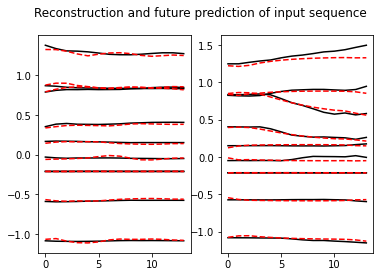

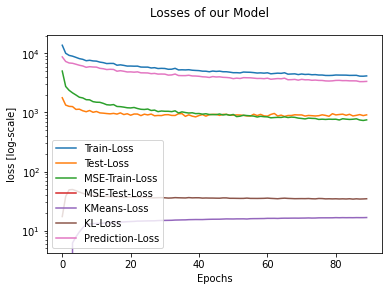

In [10]:
# Evaluate the network

vame.evaluate_model(config, model_name='VAME_prey_model')

In [11]:
# Segment behavior

vame.behavior_segmentation(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=[30])

Using CUDA
GPU active: True
GPU used: GeForce GTX 1080 Ti
Computing latent space for 09_08_2020_15_56_34_miniscope_DG_200617_b_succ_injured_nofluo 
Computing latent space for 09_08_2020_15_54_36_miniscope_DG_200617_b_succ 
Computing latent space for 09_08_2020_15_50_32_miniscope_DG_200617_b_succ 
Computing latent space for 09_08_2020_15_47_44_miniscope_DG_200617_b_succ 
Computing latent space for 09_08_2020_15_43_03_miniscope_DG_200617_b_succ 
Computing latent space for 09_08_2020_15_39_45_miniscope_DG_200617_b_succ 
Computing latent space for 09_08_2020_15_36_13_miniscope_DG_200617_b_succ_injured 
Computing latent space for 09_08_2020_15_32_30_miniscope_DG_200617_b_succ 
Computing latent space for 09_08_2020_15_26_21_miniscope_DG_200701_a_succ 
Computing latent space for 09_08_2020_15_23_32_miniscope_DG_200701_a_succ 
Computing latent space for 09_08_2020_15_20_34_miniscope_DG_200701_a_succ 
Computing latent space for 09_08_2020_15_16_25_miniscope_DG_200701_a_succ 
Computing latent sp

Computing latent space for 09_02_2020_16_50_16_miniscope_DG_200701_a_succ 
Computing latent space for 09_02_2020_16_45_55_miniscope_DG_200701_a_succ 
Computing latent space for 09_02_2020_16_41_25_miniscope_DG_200701_a_succ 
Computing latent space for 09_02_2020_16_37_35_miniscope_DG_200701_a_succ 
Computing latent space for 09_02_2020_16_34_36_miniscope_DG_200701_a_succ 
Computing latent space for 09_02_2020_16_30_27_miniscope_DG_200701_a_succ_injured 
Computing latent space for 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured 
Computing latent space for 09_01_2020_16_55_25_miniscope_DG_200617_b_succ 
Computing latent space for 09_01_2020_16_52_15_miniscope_DG_200617_b_succ_injured 
Computing latent space for 09_01_2020_16_47_10_miniscope_DG_200617_b_succ 
Computing latent space for 09_01_2020_16_43_46_miniscope_DG_200617_b_succ 
Computing latent space for 09_01_2020_16_39_52_miniscope_DG_200617_b_succ_injured 
Computing latent space for 09_01_2020_16_34_42_miniscope_DG_200617_b

Computing latent space for 08_19_2020_16_33_11_miniscope_DG_200617_b_succ_injured 
Computing latent space for 08_19_2020_16_27_02_miniscope_DG_200617_b_succ 
Computing latent space for 08_19_2020_16_16_55_miniscope_DG_200701_a_succ_noncon 
Computing latent space for 08_19_2020_16_11_32_miniscope_DG_200701_a_succ_injured 
Computing latent space for 08_19_2020_16_09_08_miniscope_DG_200701_a_succ 
Computing latent space for 08_19_2020_16_05_59_miniscope_DG_200701_a_succ_grabbedcable 
Computing latent space for 08_19_2020_16_01_41_miniscope_DG_200701_a_succ 
Computing latent space for 08_19_2020_15_58_22_miniscope_DG_200701_a_succ 
Computing latent space for 08_19_2020_15_55_28_miniscope_DG_200701_a_succ_injured 
Computing latent space for 08_19_2020_15_51_39_miniscope_DG_200701_a_succ_injured 
Computing latent space for 08_18_2020_16_45_57_miniscope_DG_200617_b_succ 
Computing latent space for 08_18_2020_16_41_33_miniscope_DG_200617_b_succ 
Computing latent space for 08_18_2020_16_38_40_m

Computing latent space for 08_12_2020_16_30_56_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_16_24_56_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_16_21_45_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_16_17_05_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_16_14_41_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_16_12_08_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_16_06_17_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_16_02_32_miniscope_DG_200617_b_succ 
Computing latent space for 08_12_2020_15_56_49_miniscope_DG_200701_a_succ 
Computing latent space for 08_12_2020_15_51_54_miniscope_DG_200701_a_succ 
Computing latent space for 08_12_2020_15_47_44_miniscope_DG_200701_a_succ 
Computing latent space for 08_12_2020_15_44_23_miniscope_DG_200701_a_succ_noncon 
Computing latent space for 08_12_2020_15_39_17_miniscope_DG_200701_a_succ 
Computing latent s

Computing latent space for 08_06_2020_17_54_57_miniscope_DG_200701_a_succ 
Computing latent space for 08_06_2020_17_47_03_miniscope_DG_200701_a_fail 
Computing latent space for 08_06_2020_17_41_32_miniscope_DG_200701_a_succ 
Computing latent space for 08_06_2020_17_37_15_miniscope_DG_200701_a_succ 
Computing latent space for 08_06_2020_17_33_37_miniscope_DG_200701_a_succ 
Computing latent space for 08_05_2020_16_20_09_miniscope_DG_200617_b_succ 
Computing latent space for 08_05_2020_16_11_00_miniscope_DG_200617_b_succ 
Computing latent space for 08_05_2020_16_06_18_miniscope_DG_200617_b_succ_earlystop 
Computing latent space for 08_05_2020_15_55_12_miniscope_DG_200617_b_succ 
Computing latent space for 08_05_2020_15_43_21_miniscope_DG_200701_a_succ 
Computing latent space for 08_05_2020_15_36_29_miniscope_DG_200701_a_succ 
Computing latent space for 08_05_2020_15_29_56_miniscope_DG_200701_a_succ 
Computing latent space for 08_05_2020_15_22_44_miniscope_DG_200701_a_succ 
Computing laten

Computing latent space for 12_16_2019_16_27_17_miniscope_MM_191108_a_succ 
Computing latent space for 12_16_2019_16_21_34_miniscope_MM_191108_a_fail 
Computing latent space for 12_12_2019_15_32_29_miniscope_MM_191108_a_succ 
Computing latent space for 12_12_2019_15_27_48_miniscope_MM_191108_a_succ 
Computing latent space for 12_12_2019_15_23_10_miniscope_MM_191108_a_fail 
Computing latent space for 12_12_2019_15_18_57_miniscope_MM_191108_a_fail 
Computing latent space for 12_12_2019_15_16_04_miniscope_MM_191108_a_succ 
Computing latent space for 12_12_2019_15_11_45_miniscope_MM_191108_a_fail 
Computing latent space for 12_12_2019_15_08_15_miniscope_MM_191108_a_succ 
Computing latent space for 12_12_2019_15_04_45_miniscope_MM_191108_a_succ 
Computing latent space for 12_12_2019_15_00_56_miniscope_MM_191108_a_succ 
Computing latent space for 12_12_2019_14_58_00_miniscope_MM_191108_a_succ_nofluo 
Computing latent space for 12_11_2019_17_14_34_miniscope_MM_191108_a_fail_miniscopeafterbonsa

Computing latent space for 12_03_2019_16_03_45_miniscope_MM_191107_a_succ_nomini 
Computing latent space for 12_03_2019_15_57_28_miniscope_MM_191107_a_succ_nomini 
Computing latent space for 12_03_2019_15_52_44_miniscope_MM_191107_a_succ_nomini 
Computing latent space for 12_03_2019_15_47_19_miniscope_MM_191107_a_succ_nomini 
Computing latent space for 12_03_2019_15_38_58_miniscope_MM_191106_a_fail_nomini 
Computing latent space for 12_03_2019_15_31_21_miniscope_MM_191106_a_fail_nomini 
Computing latent space for 12_03_2019_15_24_04_miniscope_MM_191105_a_succ_nomini 
Computing latent space for 12_03_2019_15_15_55_miniscope_MM_191105_a_succ_nomini 
Computing latent space for 12_03_2019_15_08_15_miniscope_MM_191105_a_succ_nomini 
Computing latent space for 12_03_2019_15_00_53_miniscope_MM_191105_a_fail_nomini 
Computing latent space for 12_02_2019_17_52_21_miniscope_MM_191108_a_fail_nomini 
Computing latent space for 12_02_2019_17_44_49_miniscope_MM_191108_a_fail_nomini 
Computing latent

Computing latent space for 11_11_2019_01_21_58_miniscope_DG_190806_a_fail_nofluo 
Computing latent space for 11_11_2019_00_54_37_miniscope_DG_190806_a_fail_nomini 
Computing latent space for 11_11_2019_00_49_07_miniscope_DG_190806_a_fail_nomini 
Computing latent space for 11_11_2019_00_41_27_miniscope_DG_190806_a_fail_nomini 
Behavior segmentation via k-Means for 30 cluster.
Segmentation for file 09_08_2020_15_56_34_miniscope_DG_200617_b_succ_injured_nofluo...
Segmentation for file 09_08_2020_15_54_36_miniscope_DG_200617_b_succ...
Segmentation for file 09_08_2020_15_50_32_miniscope_DG_200617_b_succ...
Segmentation for file 09_08_2020_15_47_44_miniscope_DG_200617_b_succ...
Segmentation for file 09_08_2020_15_43_03_miniscope_DG_200617_b_succ...
Segmentation for file 09_08_2020_15_39_45_miniscope_DG_200617_b_succ...
Segmentation for file 09_08_2020_15_36_13_miniscope_DG_200617_b_succ_injured...
Segmentation for file 09_08_2020_15_32_30_miniscope_DG_200617_b_succ...
Segmentation for file 0

Segmentation for file 09_02_2020_16_50_16_miniscope_DG_200701_a_succ...
Segmentation for file 09_02_2020_16_45_55_miniscope_DG_200701_a_succ...
Segmentation for file 09_02_2020_16_41_25_miniscope_DG_200701_a_succ...
Segmentation for file 09_02_2020_16_37_35_miniscope_DG_200701_a_succ...
Segmentation for file 09_02_2020_16_34_36_miniscope_DG_200701_a_succ...
Segmentation for file 09_02_2020_16_30_27_miniscope_DG_200701_a_succ_injured...
Segmentation for file 09_01_2020_16_58_35_miniscope_DG_200617_b_succ_injured...
Segmentation for file 09_01_2020_16_55_25_miniscope_DG_200617_b_succ...
Segmentation for file 09_01_2020_16_52_15_miniscope_DG_200617_b_succ_injured...
Segmentation for file 09_01_2020_16_47_10_miniscope_DG_200617_b_succ...
Segmentation for file 09_01_2020_16_43_46_miniscope_DG_200617_b_succ...
Segmentation for file 09_01_2020_16_39_52_miniscope_DG_200617_b_succ_injured...
Segmentation for file 09_01_2020_16_34_42_miniscope_DG_200617_b_succ...
Segmentation for file 09_01_2020

Segmentation for file 08_18_2020_16_31_06_miniscope_DG_200617_b_succ...
Segmentation for file 08_18_2020_16_28_42_miniscope_DG_200617_b_succ...
Segmentation for file 08_18_2020_16_25_33_miniscope_DG_200617_b_succ...
Segmentation for file 08_18_2020_16_23_10_miniscope_DG_200617_b_succ...
Segmentation for file 08_18_2020_16_15_09_miniscope_DG_200701_a_succ...
Segmentation for file 08_18_2020_16_11_41_miniscope_DG_200701_a_succ_grabbedcable...
Segmentation for file 08_18_2020_16_08_29_miniscope_DG_200701_a_succ...
Segmentation for file 08_18_2020_16_04_51_miniscope_DG_200701_a_succ...
Segmentation for file 08_18_2020_16_01_32_miniscope_DG_200701_a_succ_injured...
Segmentation for file 08_18_2020_15_59_09_miniscope_DG_200701_a_succ...
Segmentation for file 08_18_2020_15_54_55_miniscope_DG_200701_a_succ...
Segmentation for file 08_18_2020_15_51_16_miniscope_DG_200701_a_succ...
Segmentation for file 08_17_2020_16_25_53_miniscope_DG_200617_b_succ_injured...
Segmentation for file 08_17_2020_16

Segmentation for file 08_08_2020_15_57_37_miniscope_DG_200617_b_succ...
Segmentation for file 08_08_2020_15_50_40_miniscope_DG_200701_a_succ_noncon...
Segmentation for file 08_08_2020_15_47_53_miniscope_DG_200701_a_succ...
Segmentation for file 08_08_2020_15_44_28_miniscope_DG_200701_a_succ...
Segmentation for file 08_08_2020_15_38_09_miniscope_DG_200701_a_succ_injured...
Segmentation for file 08_08_2020_15_33_57_miniscope_DG_200701_a_succ_injured_noncon...
Segmentation for file 08_08_2020_15_30_48_miniscope_DG_200701_a_succ...
Segmentation for file 08_08_2020_15_27_33_miniscope_DG_200701_a_succ...
Segmentation for file 08_08_2020_15_24_06_miniscope_DG_200701_a_succ...
Segmentation for file 08_07_2020_17_13_15_miniscope_DG_200617_b_succ...
Segmentation for file 08_07_2020_17_08_34_miniscope_DG_200617_b_succ...
Segmentation for file 08_07_2020_17_03_26_miniscope_DG_200617_b_succ...
Segmentation for file 08_07_2020_16_57_16_miniscope_DG_200617_b_succ...
Segmentation for file 08_07_2020_1

Segmentation for file 12_07_2019_16_38_08_miniscope_MM_191107_a_succ_nomini...
Segmentation for file 12_07_2019_16_34_28_miniscope_MM_191107_a_succ_nomini...
Segmentation for file 12_07_2019_16_29_31_miniscope_MM_191107_a_succ_nomini...
Segmentation for file 12_07_2019_16_23_23_miniscope_MM_191106_a_succ_nomini...
Segmentation for file 12_07_2019_16_18_20_miniscope_MM_191106_a_succ_nomini...
Segmentation for file 12_07_2019_16_09_54_miniscope_MM_191105_a_succ_nomini...
Segmentation for file 12_07_2019_16_05_30_miniscope_MM_191105_a_succ_nomini...
Segmentation for file 12_07_2019_15_56_10_miniscope_MM_191108_a_fail...
Segmentation for file 12_07_2019_15_52_11_miniscope_MM_191108_a_succ...
Segmentation for file 12_07_2019_15_47_28_miniscope_MM_191108_a_succ...
Segmentation for file 12_07_2019_15_43_37_miniscope_MM_191108_a_succ...
Segmentation for file 12_07_2019_15_39_33_miniscope_MM_191108_a_succ...
Segmentation for file 12_07_2019_15_34_47_miniscope_MM_191108_a_succ...
Segmentation fo

Segmentation for file 11_25_2019_14_55_06_miniscope_MM_191105_a_fail_nomini...
Segmentation for file 11_25_2019_14_47_40_miniscope_MM_191105_a_fail_nomini...
Segmentation for file 11_25_2019_14_38_45_miniscope_MM_191105_a_fail_nomini...
Segmentation for file 11_25_2019_14_30_43_miniscope_MM_191105_a_fail_nomini...
Segmentation for file 11_14_2019_17_50_12_miniscope_DG_190810_a_succ_nomini...
Segmentation for file 11_14_2019_17_46_42_miniscope_DG_190810_a_succ_nomini...
Segmentation for file 11_14_2019_17_43_07_miniscope_DG_190810_a_succ_nomini...
Segmentation for file 11_14_2019_17_39_46_miniscope_DG_190810_a_succ_nomini...
Segmentation for file 11_14_2019_17_30_44_miniscope_DG_190806_a_succ_nofluo...
Segmentation for file 11_14_2019_17_24_28_miniscope_DG_190806_a_succ_nofluo...
Segmentation for file 11_14_2019_17_19_46_miniscope_DG_190806_a_succ_nofluo...
Segmentation for file 11_14_2019_17_15_24_miniscope_DG_190806_a_succ_nofluo...
Segmentation for file 11_13_2019_18_25_56_miniscope_

In [12]:
# Quantify behavior

vame.behavior_quantification(config, model_name='VAME_prey_model', cluster_method='kmeans', n_cluster=30)

C:\Users\setup\.conda\envs\vame\lib\site-packages\vame-0.1-py3.7.egg\vame\analysis\behavior_structure.py:56: RuntimeWarning: invalid value encountered in true_divide
